<a href="https://colab.research.google.com/github/maheshwariram/open-science/blob/main/notebooks/notebook-3-learn-models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Learn machine learning models

This tutorial demonstrates how to learn machine learning models to value on-the-ball actions of football players with the open-source [VAEP framework](https://github.com/ML-KULeuven/socceraction) using the publicly available [Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000). The Wyscout dataset includes data for the 2017/2018 English Premier League, the 2017/2018 Spanish Primera División, the 2017/2018 German 1. Bundesliga, the 2017/2018 Italian Serie A, the 2017/2018 French Ligue 1, the 2018 FIFA World Cup, and the UEFA Euro 2016. Covering 1,941 matches, 3,251,294 events and 4,299 players, the dataset is large enough to train machine-learning models and obtain robust ratings for the players.

This tutorial demonstrates the following four steps:
1. Split the dataset into a training set and a test set.
2. Construct the baseline classifiers by using conservative hyperparameters for the learning algorithm.
3. Optimize the classifiers by tuning the hyperparameters for the learning algorithm.
4. Construct the final classifiers using the optimal hyperparameters for the learning algorithm.

This notebook is compatible with `socceraction` version `0.2.0`.

**Conventions:**
* Variables that refer a `DataFrame` object are prefixed with `df_`.
* Variables that refer a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References:**
* Tom Decroos, Lotte Bransen, Jan Van Haaren, and Jesse Davis. "[Actions Speak Louder than Goals: Valuing Player Actions in Soccer.](https://arxiv.org/abs/1802.07127)" In *Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining*, pp. 1851-1861. 2019.
* Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions.](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.

**Optional:** If you run this notebook on Google Colab, then uncomment the code in the following cell and execute the cell.

In [1]:
!pip install tables==3.6.1
!pip install scikit-plot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tables
  Running setup.py clean for tables
Failed to build tables
ERROR: Could not build wheels for tables, which is required to install pyproject.toml-based projects


**Optional:** If you run this notebook on Google Colab and wish to store all data in a Google Drive folder, then uncomment the code in the following cell and execute the cell.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
%mkdir -p '/content/gdrive/My Drive/Friends of Tracking/'
%cd '/content/gdrive/My Drive/Friends of Tracking/'

Mounted at /content/gdrive
/content/gdrive/My Drive/Friends of Tracking


In [3]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scikitplot.metrics import plot_calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

In [4]:
warnings.filterwarnings('ignore', category=pd.io.pytables.PerformanceWarning)

In [5]:
%matplotlib inline

# Load dataset

This third tutorial assumes that the `spadl.h5` HDF5 file as well as the `features.h5` and `labels.h5` files have been created for a set of games in the first or second tutorial.

This third tutorial only uses features that have been generated in the first tutorial. However, you are strongly encouraged to toy around with the additional features from the second tutorial and to try out your own features to improve the accuracy of the predictive machine learning models!

## Load games

In [6]:
df_games = pd.read_hdf('spadl.h5', key='games')

**Optional:** If you plan to produce results for a particular season in the Wyscout match event dataset (e.g., 2017/2018 English Premier League), you should consider leaving that season out of the dataset to avoid the same game states from appearing in both the training set and the test set. If you would like to only include a particular subset of games, then uncomment the code in the following cell, adapt the selector and execute the cell. The example selector will select all games that were played in the 2017/2018 English Premier League.

In [7]:
# df_games = df_games[
#     df_games['competition_id'] == 364
# ]

In [8]:
df_games.tail(10)

,game_id,competition_id,season_id,game_date,home_team_id,away_team_id
54,2057984,28,10078,2018-06-17 15:00:00,3148,15473
55,2057979,28,10078,2018-06-17 12:00:00,16871,17322
56,2057973,28,10078,2018-06-16 19:00:00,9598,16823
57,2057967,28,10078,2018-06-16 16:00:00,15594,7712
58,2057972,28,10078,2018-06-16 13:00:00,12274,7839
59,2057966,28,10078,2018-06-16 10:00:00,4418,8493
60,2057960,28,10078,2018-06-15 18:00:00,9905,1598
61,2057961,28,10078,2018-06-15 15:00:00,16216,10840
62,2057955,28,10078,2018-06-15 12:00:00,16129,15670
63,2057954,28,10078,2018-06-14 15:00:00,14358,16521


## Load features

Load the *features* for the selected games and combine them into the `df_features` `DataFrame` object.

In [9]:
dfs_features = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    df_features['game_id'] = game_id
    dfs_features.append(df_features)
df_features = pd.concat(dfs_features).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [10]:
df_features.tail(10)

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
618541,2057954.0,2.0,2860.543201,14358.0,102157.0,58.80,41.48,58.80,38.08,0,...,0.64,0.44,38.019553,9.264706,4.20,14.28,5.269374,4.20,10.88,2057954
618542,2057954.0,2.0,2861.719049,14358.0,102157.0,58.80,38.08,69.30,45.56,0,...,0.56,0.61,46.801607,6.176471,-8.40,8.16,4.900802,2.10,15.64,2057954
618543,2057954.0,2.0,2863.131899,14358.0,4513.0,69.30,45.56,55.65,42.16,0,...,0.56,0.56,46.379806,11.323529,10.50,4.08,2.588698,-3.15,0.68,2057954
618544,2057954.0,2.0,2864.548384,14358.0,220971.0,55.65,42.16,72.45,24.48,0,...,0.66,0.67,37.524973,3.088235,-3.15,4.08,2.829335,13.65,-13.60,2057954
618545,2057954.0,2.0,2865.964868,14358.0,220971.0,72.45,24.48,76.65,19.04,0,...,0.53,0.62,50.020077,6.047794,3.15,-21.08,2.832969,7.35,-26.52,2057954
618546,2057954.0,2.0,2868.496551,14358.0,103682.0,76.65,19.04,81.90,20.40,0,...,0.69,0.36,33.913609,3.419118,21.00,-23.12,3.948167,26.25,-21.76,2057954
618547,2057954.0,2.0,2870.980334,16521.0,122577.0,81.90,20.40,80.85,25.16,0,...,0.27,0.72,78.096249,5.123663,49.35,-23.12,5.015466,48.30,-18.36,2057954
618548,2057954.0,2.0,2872.843120,16521.0,122577.0,80.85,25.16,80.85,25.16,0,...,0.22,0.70,83.021503,6.022059,52.50,-23.80,4.346569,52.50,-23.80,2057954
618549,2057954.0,2.0,2939.438099,14358.0,257800.0,85.05,22.44,105.00,30.60,0,...,0.23,0.63,81.331839,9.145928,61.95,-25.16,68.457765,81.90,-17.00,2057954
618550,2057954.0,2.0,2983.382036,16521.0,122623.0,52.50,34.00,0.00,68.00,0,...,0.77,0.37,25.717078,2.731900,-28.35,8.84,110.538916,-80.85,42.84,2057954


## Load labels

Load the *labels* for the selected games and combine them into the `df_labels` `DataFrame` object.

In [11]:
dfs_labels = []
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    df_labels['game_id'] = game_id
    dfs_labels.append(df_labels)
df_labels = pd.concat(dfs_labels).reset_index(drop=True)

  0%|          | 0/495 [00:00<?, ?it/s]

In [12]:
df_labels.tail(10)

,scores,concedes,game_id
618541,True,False,2057954
618542,True,False,2057954
618543,True,False,2057954
618544,True,False,2057954
618545,True,False,2057954
618546,True,False,2057954
618547,False,True,2057954
618548,False,True,2057954
618549,True,False,2057954
618550,False,False,2057954


# Split dataset

To accurately predict the labels for game states, the challenge is to train a robust machine learning model that generalizes well from *observed* game states (e.g., game states in games that have been played already) to *unobserved* game states (e.g., game states in games that are yet to be played). Hence, the machine learning model needs to capture interactions between features of game states that are not too specific to identify *similar* game states yet specific enough to distinguish between *dissimilar* game states.

Typically, a machine learning model is said to be *overfitted* on the data if the interactions are too specific (i.e., apply to just a few game states) and is said to be *underfitted* on the data if the interactions are too general (i.e., apply to about all game states). To avoid underfitting, we define an expressive set of features and use a machine learning algorithm that learns a model that can capture complex relationships between these features. To avoid overfitting, we apply [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html) to assess how well a candidate model would perform in practice and apply regularization techniques to keep the learned model as simple as possible.

In this tutorial, we will apply the following methodology:
1. Split the available data into a training set and a test set. The training set will be used to learn the machine learning model, whereas the test set will be kept aside until the very end to assess the real-world performance of the learned model.
2. Learn models with different values for the hyperparameters of the learning algorithm on the training set by adopting a $k$-fold cross-validation setup:
  * Split the training set in $k$ random folds or subsets of equal size.
  * Use $k$-1 training folds to train the model and compute the evaluation metric on the remaining validation fold.
  * Repeat $k$ times until each fold has served as the validation fold once.
3. Select the values for the hyperparameters that yield the best performance across the $k$ validation folds according to the evaluation metric.
4. Train the final model on the full training set using the optimal values for the hyperparameters.
5. Apply the final model on the test set and compute the evaluation metric.

The following cell splits the available data into a training set and test set using the `train_test_split` function.

* **Test set size:** The `test_size` parameter controls the number of examples in the test set. The challenge is to find an appropriate balance between the number of training examples and the number of test examples. Typically, more training examples yield better models, whereas more test examples yield more reliable evaluation metrics.
* **Random state:** The `random_state` parameter sets the *seed* for the random number generator. By setting a *seed*, the train-test split will be the same for each execution of the `train_test_split` function, which is important for reproducing the results and comparing different models.
* **Stratification:** The `stratify` parameter enforces a *stratified* train-test split according to the provided class label. By doing so, the distribution of the provided class label will be the same in the training set and the test set, which can be helpful to obtain a well-calibrated model. Since we will be using two different class labels (i.e., `scores` and `concedes`), we use a concatenation of both class labels for the stratification procedure.

In [13]:
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(
    df_features,
    df_labels,
    test_size=0.10,
    random_state=42,
    stratify=df_labels['scores'].astype(str) + '_' + df_labels['concedes'].astype(str)
)

The following cells inspect whether the training set and test set have the same proportion of positive and negative examples for each class.

In [14]:
df_y_train['scores'].mean()

0.015487834451539891

In [15]:
df_y_test['scores'].mean()

0.015487584066218314

In [16]:
df_y_train['concedes'].mean()

0.005205723061999838

In [17]:
df_y_test['concedes'].mean()

0.005205638903259183

**Note:** In a real-world scenario where more data is available, you should consider respecting the chronological order of the games to construct the training set, validation set and test set. For instance, use the data for the 2016/2017 and 2017/2018 seasons to train the models, use the data for the 2018/2019 season to tune the models, and use the data for the 2019/2020 season to obtain the results.

# Construct baseline classifiers

The following cell provides a list of features that the machine learning algorithm will consider to train the model.

In [18]:
features = [
    'start_distance_to_goal-0',
    'end_distance_to_goal-0',
    'start_distance_to_goal-1',
    'end_distance_to_goal-1',
    'start_distance_to_goal-2',
    'end_distance_to_goal-2',
    'start_angle_to_goal-0',
    'end_angle_to_goal-0',
    'start_angle_to_goal-1',
    'end_angle_to_goal-1',
    'start_angle_to_goal-2',
    'end_angle_to_goal-2',
    'team-1',
    'team-2'
]

The following cell provides a list of class labels for which the machine learning algorithm will train a model.

**Note:** The `concedes` class label has been commented to speed up the execution of the entire notebook.

In [19]:
labels = [
    'scores',
#     'concedes'
]

## Train classifiers

The following cell trains an XGBoost classifier for each label using *conservative* hyperparamters for the learning algorithm, which will serve as *baseline* models.

In [20]:
%%time
models = {}
for label in tqdm(labels):
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_estimators=10,
        max_depth=3
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models[label] = model

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 4.23 s, sys: 234 ms, total: 4.46 s
Wall time: 4.04 s


## Estimate probabilities

The following cell estimates the probabilities for each label using the trained *baseline* models.

In [21]:
dfs_predictions = {}
for label in tqdm(labels):
    model = models[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
df_predictions.head(10)

,scores
116871,0.015002
189362,0.015195
111940,0.018929
392335,0.050173
305171,0.015195
397716,0.021432
277721,0.015002
458543,0.015002
198065,0.015002
190851,0.015606


## Evaluate probabilities

### Compute base rate probabilities

The following cell computes the *base rate* or *prior probability* of each class label in the training set. We use the *base rate* as a naive estimate for each example in the test set being true to establish a baseline for the evaluation metrics.

In [23]:
df_base_rates = pd.DataFrame({
    label:np.full(len(df_y_test[label]), df_y_train[label].mean()) for label in labels
})

In [24]:
df_base_rates.head(10)

,scores
0,0.015488
1,0.015488
2,0.015488
3,0.015488
4,0.015488
5,0.015488
6,0.015488
7,0.015488
8,0.015488
9,0.015488


### Compute Brier score loss for goal scored model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [25]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015247718806072823

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [26]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions['scores']
)

0.014745331859525762

### Compute Brier score loss for goal conceded model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [27]:
# brier_score_loss(
#     y_true=df_y_test['concedes'],
#     y_prob=df_base_rates['concedes']
# )

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [28]:
# brier_score_loss(
#     y_true=df_y_test['concedes'],
#     y_prob=df_predictions['concedes']
# )

### Plot calibration curve and probability histogram

The following cell creates a plot to show both a calibration curve and a probability histogram.

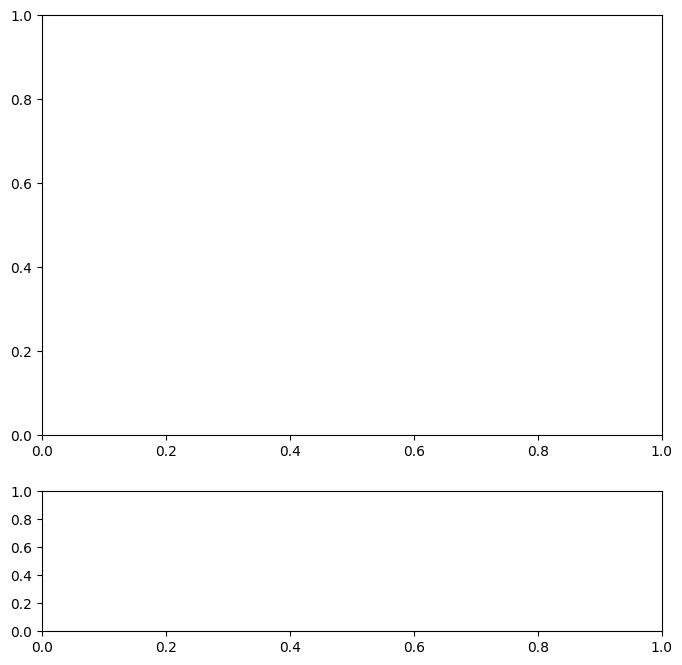

In [29]:
fig, (ax1, ax2) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)

The following cell plots the *calibration curve* for the trained model.

In [30]:
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1
)

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

The following cell plots the histogram of the predictions produced by the trained model. Clearly, the majority of the examples is *negative*, which means that the start of the calibration curve is extremely important.

In [31]:
df_predictions['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2
)

<Axes: ylabel='Frequency'>

# Optimize classifiers

In order to train *accurate* models, we perform a *grid search* over different combinations of parameter values for the most important hyperparameters for the learning algorithm. We will focus on the number of estimators and the maximum depth of the decision trees although more hyperparameters influence the performance of the trained models. The more combinations of parameter values need to be explored, the longer the *grid search* will take.

Furthermore, restricting the number of estimators (i.e., the number of decision trees) and the maximum depth of the decision trees is an important mechanism to reduce the complexity of the trained models and thus also to avoid overfitting on the training data. The more decision trees that the learning algorithm can use and the deeper these decision trees can become, the more opportunities the learning algorithm has to *memorize* the training data rather than to discover patterns that generalize to the unseen test data.

## Train classifiers

The following cell trains an XGBoost classifier for each label by trying different combinations of hyperparameters.

In [32]:
%%time
models_cv = {}
for label in tqdm(labels):
    model = GridSearchCV(
        estimator=XGBClassifier(
            eval_metric='logloss',
            use_label_encoder=False,
        ),
        param_grid={
            'n_estimators': [50, 100],
            'max_depth': [3, 4]
        },
        scoring='neg_brier_score',
        refit=True,  # train final model on full training set using best hyperparameters
        verbose=10,
        n_jobs=1
    )
    model.fit(
        X=df_X_train[features],
        y=df_y_train[label]
    )
    models_cv[label] = model

  0%|          | 0/1 [00:00<?, ?it/s]

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 1/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   4.6s
[CV 2/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 2/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   3.2s
[CV 3/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 3/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   3.2s
[CV 4/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 4/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   5.6s
[CV 5/5; 1/4] START max_depth=3, n_estimators=50................................
[CV 5/5; 1/4] END max_depth=3, n_estimators=50;, score=-0.014 total time=   4.6s
[CV 1/5; 2/4] START max_depth=3, n_estimators=100...............................
[CV 1/5; 2/4] END max_depth=3, n_estimators=100;,

**Note:** We have considered a manually selected set of features to represent the game states. In addition to optimizing the hyperparameters for the learning algorithm, we could also optimize the set of features to be considered by the learning algorithm. However, the XGBoost algorithm should be able to figure out by itself which features are most important to include in the model by the nature of the algorithm.

## Estimate probabilities

The following cell estimates the probabilities for each label using the trained *baseline* models.

In [33]:
dfs_predictions_cv = {}
for label in tqdm(labels):
    model = models_cv[label]
    probabilities = model.predict_proba(
        df_X_test[features]
    )
    predictions = probabilities[:, 1]
    dfs_predictions_cv[label] = pd.Series(predictions, index=df_X_test.index)
df_predictions_cv = pd.concat(dfs_predictions, axis=1)

  0%|          | 0/1 [00:00<?, ?it/s]

## Evaluate probabilities

### Compute Brier score loss for goal scored model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [34]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_base_rates['scores']
)

0.015247718806072823

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [35]:
brier_score_loss(
    y_true=df_y_test['scores'],
    y_prob=df_predictions_cv['scores']
)

0.014745331859525762

### Compute Brier score loss for goal conceded model

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the base rate predictions.

In [36]:
# brier_score_loss(
#     y_true=df_y_test['concedes'],
#     y_prob=df_base_rates['concedes']
# )

The following cell computes the [Brier loss score](https://en.wikipedia.org/wiki/Brier_score) for the predictions by the learned model.

In [37]:
# brier_score_loss(
#     y_true=df_y_test['concedes'],
#     y_prob=df_predictions_cv['concedes']
# )

### Plot calibration curve and probability histogram

The following cell creates a plot to show both a calibration curve and a probability histogram.

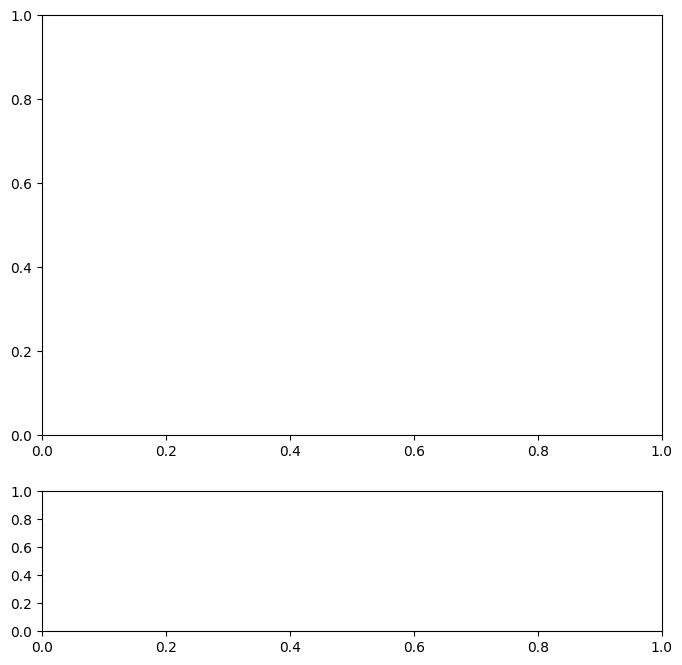

In [38]:
fig_cv, (ax1_cv, ax2_cv) = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 8),
    gridspec_kw={
        'height_ratios': [3, 1]
    }
)

The following cell plots the *calibration curve* for the trained model.

In [39]:
plot_calibration_curve(
    y_true=df_y_test['scores'],
    probas_list=[df_predictions_cv['scores'].tolist()],
    clf_names=['Goal scored model'],
    n_bins=10,
    ax=ax1_cv
)

<Axes: title={'center': 'Calibration plots (Reliability Curves)'}, xlabel='Mean predicted value', ylabel='Fraction of positives'>

The following cell plots the histogram of the predictions produced by the trained model. Clearly, the majority of the examples is *negative*, which means that the start of the calibration curve is extremely important.

In [40]:
df_predictions_cv['scores'].plot.hist(
    range=(0, 1),
    bins=10,
    ax=ax2_cv
)

<Axes: ylabel='Frequency'>

## Optional: Calibrate probabilities

If the trained model produces poorly calibrated probability estimates, the probability estimates can be re-calibrated using [CalibratedClassifierCV](https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html), which performs probability calibration with isotonic regression or logistic regression.

# Construct final classifiers

Once we have found the *best* feature set and *best* hyperparameters for the learning algorithm, we can learn the final model.

1. If we use `GridSearchCV` and the `refit` parameter was set to `True`, we can retrieve the *final* model, which has been re-trained on the entire training set, by accessing the `best_estimator_` attribute of the object.
2. We can manually train the *final* model by creating a `XGBClassifier` object using the *best* hyperparameters and calling the `fit` method with the entire training set.

## Option 1: Retrieve classifier from grid search

In [41]:
model_scores = models_cv['scores']

The following cell shows the *best* hyperparameter combination that was found using the *grid search*.

In [42]:
pd.Series(
    model_scores.best_params_
)

max_depth        4
n_estimators    50
dtype: int64

The following cell shows the full results of the *grid search*.

In [43]:
pd.DataFrame(
    model_scores.cv_results_
)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,4.021423,0.876753,0.227163,0.066233,3,50,"{'max_depth': 3, 'n_estimators': 50}",-0.014430,-0.014321,-0.014193,-0.014250,-0.014279,-0.014294,0.000079,4
1,5.888513,1.534718,0.294375,0.085311,3,100,"{'max_depth': 3, 'n_estimators': 100}",-0.014396,-0.014276,-0.014160,-0.014169,-0.014226,-0.014245,0.000086,3
2,4.102740,1.355234,0.226998,0.066701,4,50,"{'max_depth': 4, 'n_estimators': 50}",-0.014380,-0.014266,-0.014133,-0.014202,-0.014189,-0.014234,0.000084,1
3,6.624370,2.079644,0.247154,0.006105,4,100,"{'max_depth': 4, 'n_estimators': 100}",-0.014398,-0.014278,-0.014148,-0.014197,-0.014192,-0.014243,0.000088,2


The following cell shows the hyperparameters that were used to re-train the model on the entire training set.

In [44]:
pd.Series(
    model_scores.best_estimator_.get_params()
)

objective                  binary:logistic
base_score                            None
booster                               None
callbacks                             None
colsample_bylevel                     None
colsample_bynode                      None
colsample_bytree                      None
device                                None
early_stopping_rounds                 None
enable_categorical                   False
eval_metric                        logloss
feature_types                         None
gamma                                 None
grow_policy                           None
importance_type                       None
interaction_constraints               None
learning_rate                         None
max_bin                               None
max_cat_threshold                     None
max_cat_to_onehot                     None
max_delta_step                        None
max_depth                                4
max_leaves                            None
min_child_w

The following cell retrieves the final `XGBClassifier` object from the `GridSearchCV` object.

In [45]:
model_scores_final = model_scores.best_estimator_

In [46]:
model_scores_final

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Option 2: Train classifier using optimal hyperparameters

The following cell constructs a new `XGBoostClassifier` object using the *best* hyperparameters that were found by the *grid search*.

In [47]:
model_scores_final = XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    n_estimators=100,
    max_depth=4
)

The following cell fits the `XGBoostClassifier` object on the entire training set.

In [48]:
model_scores_final.fit(
    X=df_X_train[features],
    y=df_y_train[label]
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)